In [40]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib
import scipy.stats as scs

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from itertools import product

from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['lines.linewidth'] = 1.0

In [2]:
df = pd.read_excel('Uninstall 042018-082019.xlsx', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 2018-01-01 to 2019-07-15
Data columns (total 1 columns):
Daily User Uninstalls    561 non-null int64
dtypes: int64(1)
memory usage: 8.8 KB


In [3]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
data = df['Daily User Uninstalls']

# Stationarize

In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

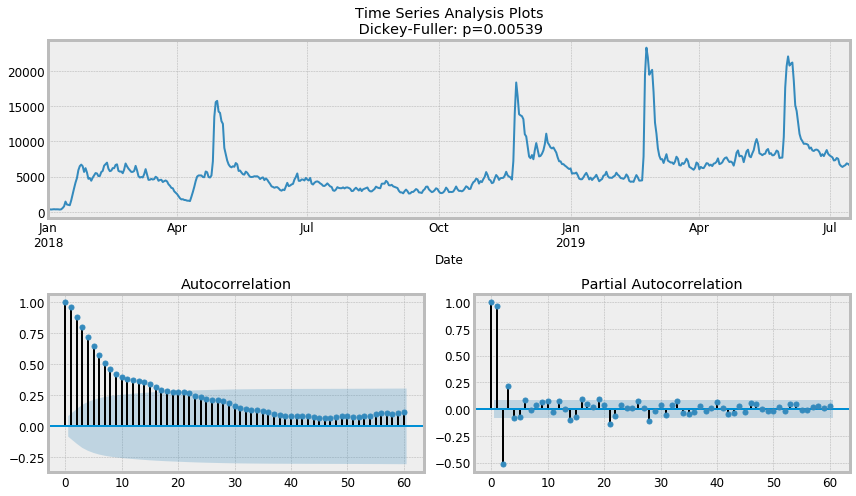

In [6]:
tsplot(data, lags=60)

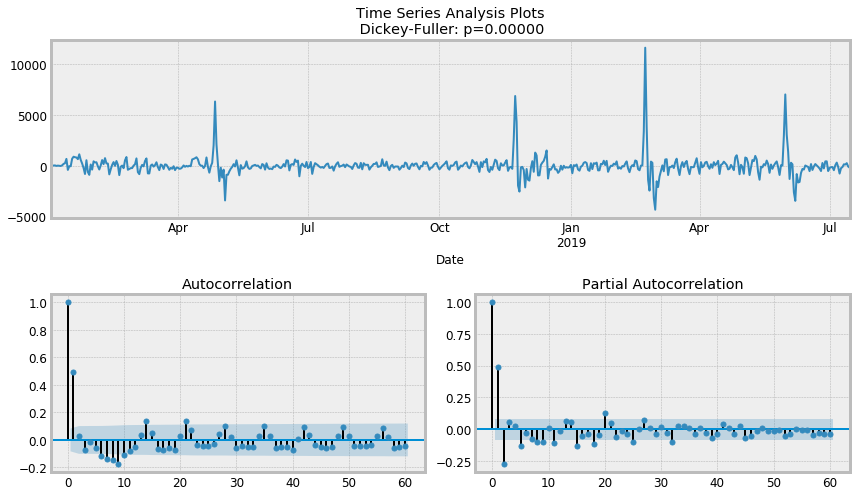

In [7]:
d_shifted = 1

df_diff = data - data.shift(d_shifted)
tsplot(df_diff[d_shifted:], lags=60)

# SARIMA

In [8]:
ps = range(1, 4)
d=1 
qs = range(0, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [9]:
def optimizeSARIMA(data, parameters_list, d, D, s):
  """
    Return dataframe with parameters and corresponding AIC
    
    data - list with data of uninstall
    parameters_list - list with (p, q, P, Q) tuples
    d - integration order in ARIMA model
    D - seasonal integration order 
    s - length of season
  """
  results = []
  best_aic = float("inf")

  for param in tqdm_notebook(parameters_list):
      # we need try-except because on some combinations model fails to converge
      try:
          model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
      except:
          continue
      aic = model.aic
      # saving best model, AIC and parameters
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results.append([param, model.aic])

  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic']
  # sorting in ascending order, the lower AIC is - the better
  result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
  
  return result_table

In [10]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
    return pd.DataFrame(forecast)
    

In [11]:
from tqdm import tqdm_notebook
result_table = optimizeSARIMA(data,parameters_list, d, D, s)

In [12]:
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data,
                                       order=(p, d, q),
                                       seasonal_order=(P, D, Q, s))\
                                       .fit(disp=-1)

0
2019-07-16  6877.871536
2019-07-17  7085.036800
2019-07-18  7315.702127
2019-07-19  8008.150891
2019-07-20  8675.774523
2019-07-21  8498.355051
2019-07-22  7959.496586
2019-07-23  7961.535671
2019-07-24  7981.036041
2019-07-25  8094.755072
2019-07-26  8592.057705
2019-07-27  9104.618105
2019-07-28  8877.792933
2019-07-29  8343.655245
2019-07-30  8342.169964

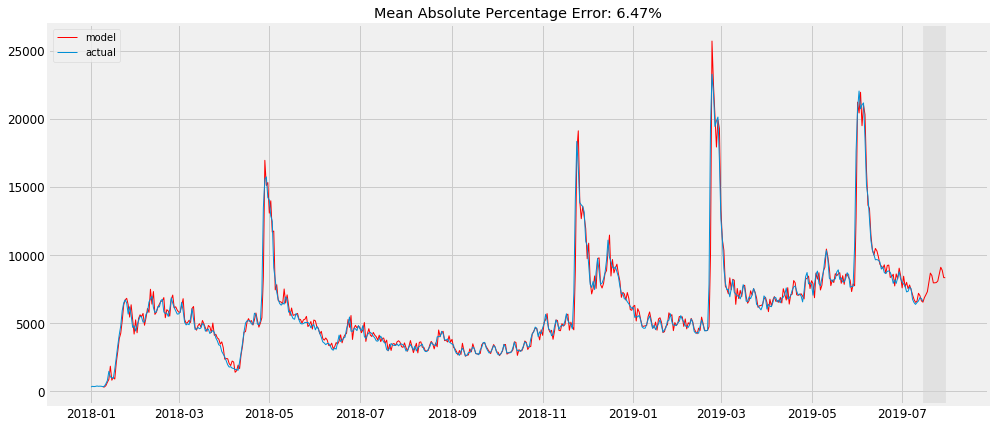

In [13]:
plotSARIMA(pd.DataFrame(data), best_model, 14).tail(15)

# Linear Models with time lags

## Preprocessing

In [157]:
lag_range = [7, 17]

In [158]:
lm_data = pd.DataFrame(data)
lm_data.columns = ['y']

In [159]:
for i in range(lag_range[0], lag_range[1]):
  lm_data['lag_{}'.format(i)] = lm_data.y.shift(i)

In [160]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=5)

In [161]:
def timeseries_train_test_split(X, y, test_size):
  test_index = int(len(X) * (1-test_size))
  
  X_train = X.iloc[:test_index]
  y_train = y.iloc[:test_index]
  X_test = X.iloc[test_index:]
  y_test = y.iloc[test_index:]
  
  return X_train, X_test, y_train, y_test

In [162]:
y = lm_data.dropna().y
X = lm_data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

## Functions

In [163]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(10, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

## Linear Regression

In [164]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

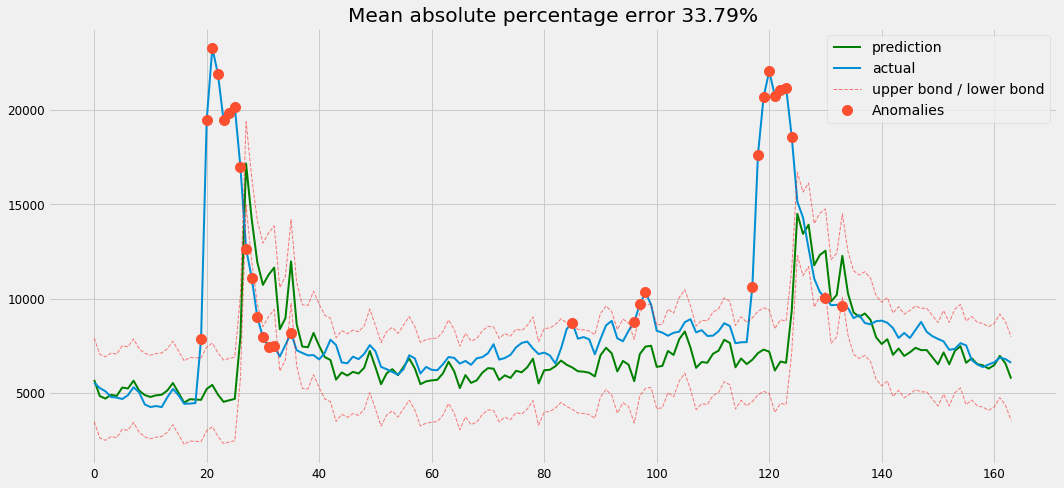

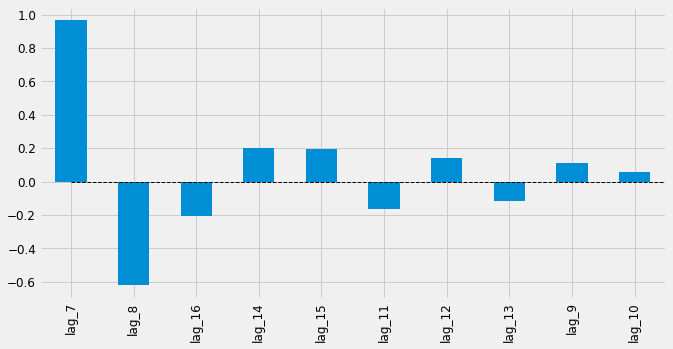

In [165]:
plotModelResults(model, plot_intervals=True, plot_anomalies=True)
plotCoefficients(model)

## Featues Extracting and Scaling

In [166]:
lm_data.index = pd.to_datetime(lm_data.index)
# lm_data['day'] = lm_data.index.day
lm_data['weekday'] = lm_data.index.weekday
lm_data['is_weekend'] = lm_data.weekday.isin([4,5])*1

lm_data['weekday_to_predict'] = lm_data.index.shift(periods=7, freq='D').weekday
lm_data['is_weekend_to_predict'] = lm_data.weekday_to_predict.isin([4,5])*1
lm_data.tail()

y   lag_7   lag_8   lag_9  lag_10  lag_11  lag_12  lag_13  \
Date                                                                       
2019-07-11  6514  7293.0  7735.0  7868.0  8014.0  8242.0  8769.0  8340.0   
2019-07-12  6628  7338.0  7293.0  7735.0  7868.0  8014.0  8242.0  8769.0   
2019-07-13  6877  7643.0  7338.0  7293.0  7735.0  7868.0  8014.0  8242.0   
2019-07-14  6797  7526.0  7643.0  7338.0  7293.0  7735.0  7868.0  8014.0   
2019-07-15  6605  6752.0  7526.0  7643.0  7338.0  7293.0  7735.0  7868.0   

            lag_14  lag_15  lag_16  weekday  is_weekend  weekday_to_predict  \
Date                                                                          
2019-07-11  7916.0  8185.0  7918.0        3           0                   3   
2019-07-12  8340.0  7916.0  8185.0        4           1                   4   
2019-07-13  8769.0  8340.0  7916.0        5           1                   5   
2019-07-14  8242.0  8769.0  8340.0        6           0                   6   
2019-07-15  8014.0  8242.0  8769.0        0           0                   0   

            is_weekend_to_predict  
Date                               
2019-07-11                      0  
2019-07-12                      1  
2019-07-13                      1  
2019-07-14                      0  
2019-07-15                      0

In [167]:
y = lm_data.dropna().y
X = lm_data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


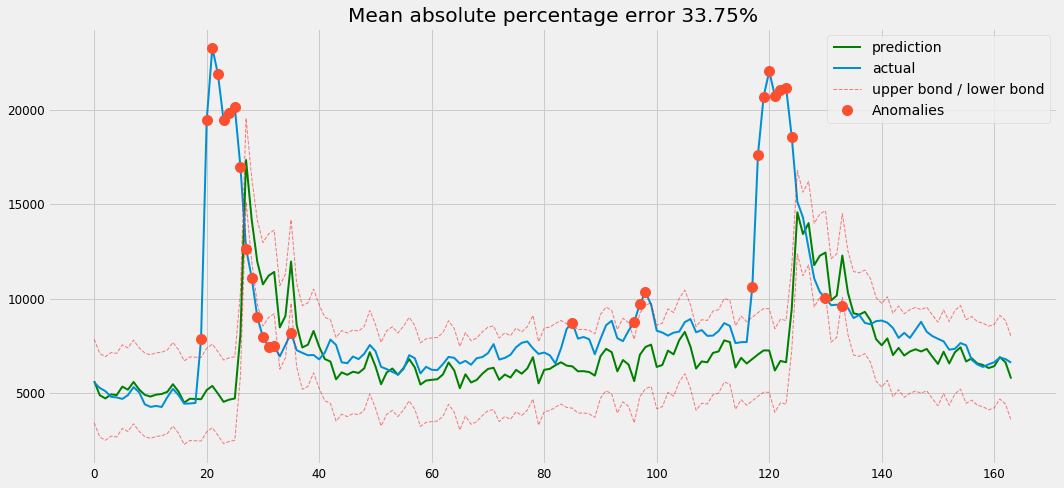

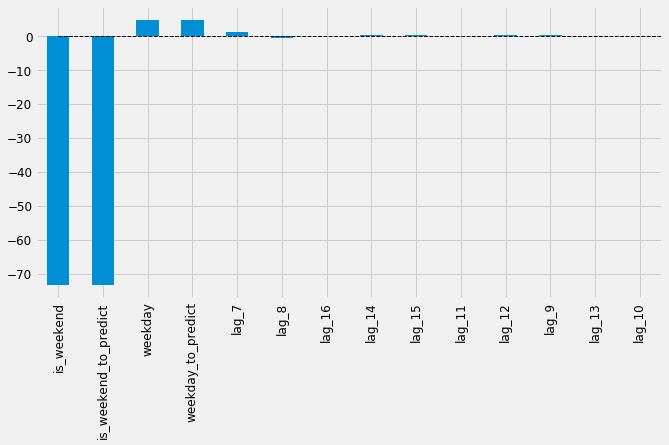

In [168]:
lr.fit(X_train, y_train)

plotModelResults(lr, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

## Ridge And Lasso

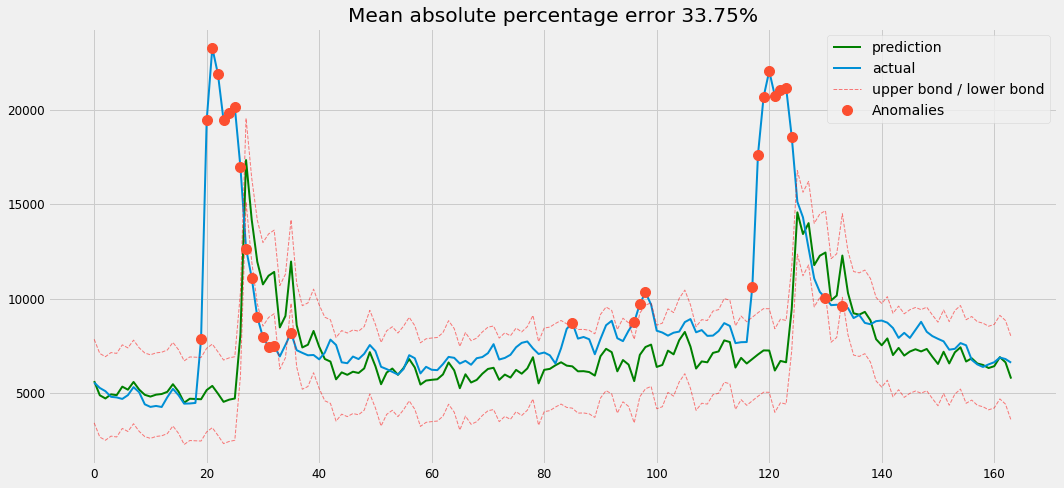

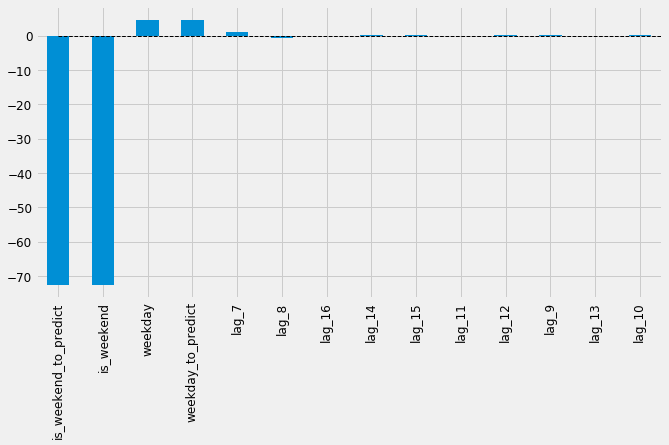

In [169]:
ridge = RidgeCV(alphas=[0.3, 0.5, 0.7, 0.9],cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True,
                 plot_anomalies=True)
plotCoefficients(ridge)

In [170]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

l_params = {
    'eps': [0.0001, 0.001, 0.01, 0.1],
    'n_alphas': [1, 2, 4, 5, 10, 15, 20, 25]
}

l_search = GridSearchCV(lasso, l_params, cv=5,
                        scoring='neg_mean_squared_error',
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1)
l_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LassoCV(alphas=None, copy_X=True,
                               cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                               eps=0.001, fit_intercept=True, max_iter=1000,
                               n_alphas=100, n_jobs=None, normalize=False,
                               positive=False, precompute='auto',
                               random_state=None, selection='cyclic',
                               tol=0.0001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'eps': [0.0001, 0.001, 0.01, 0.1],
                         'n_alphas': [1, 2, 4, 5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=2)

In [171]:
l_search.best_params_

{'eps': 0.01, 'n_alphas': 1}

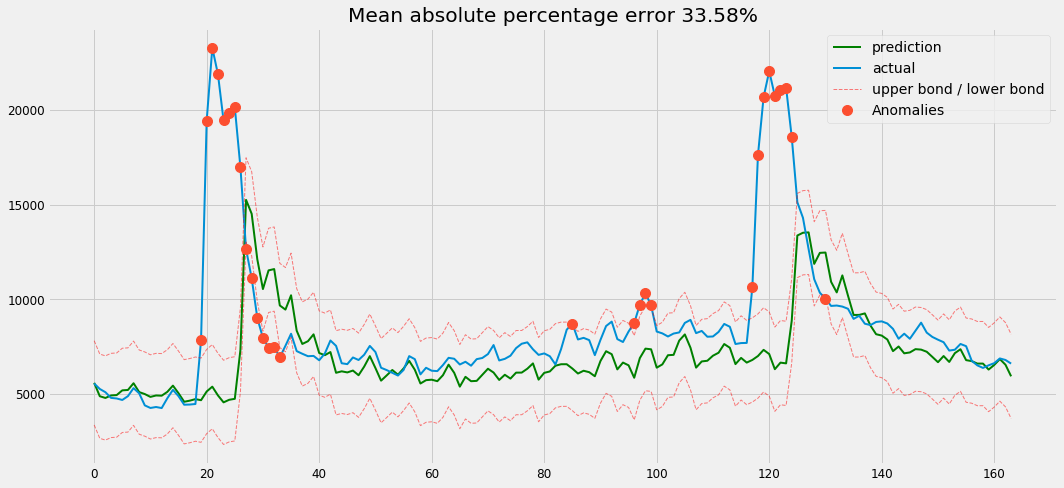

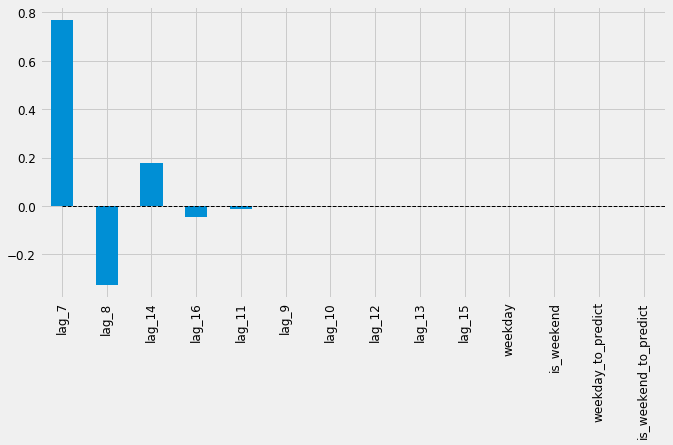

In [172]:
lasso = l_search.best_estimator_

plotModelResults(lasso,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True,
                 plot_anomalies=True)

plotCoefficients(lasso)

## Gradient Boosting Regression

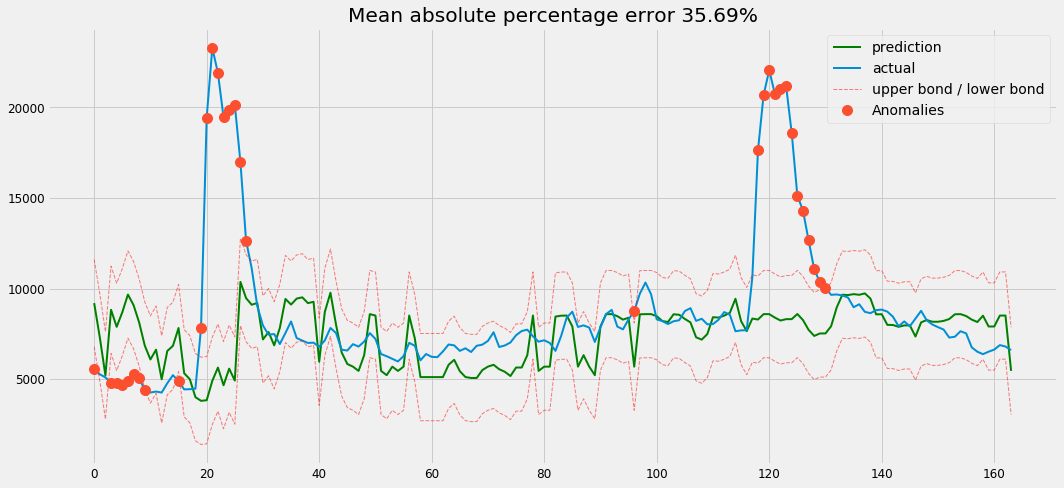

In [173]:
xgb = GradientBoostingRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True,
                 plot_anomalies=True
                )

[16:52:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


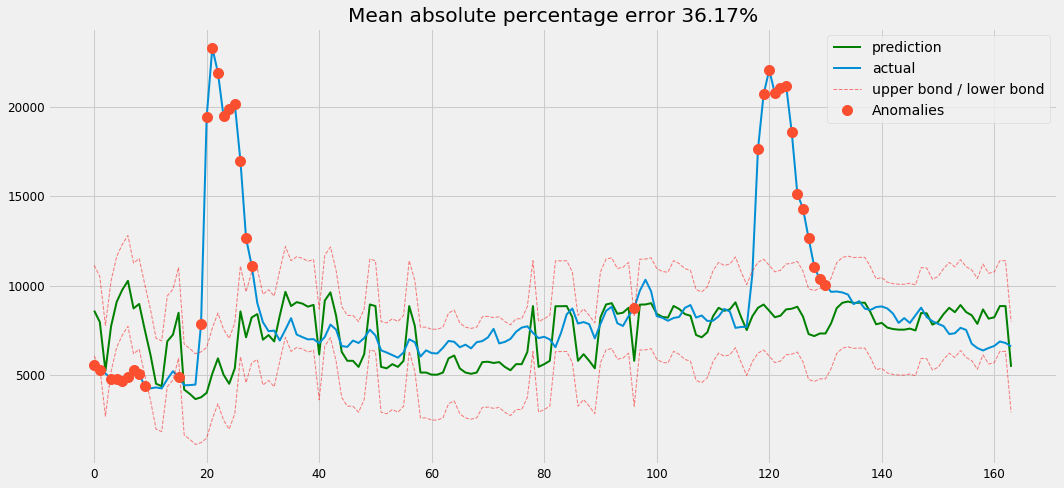

In [174]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

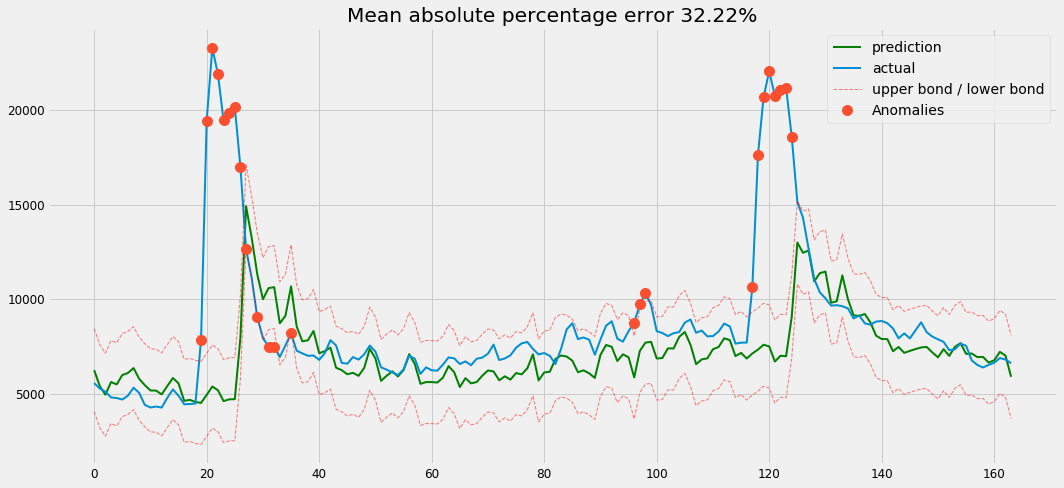

In [175]:
from sklearn.ensemble import VotingRegressor

reg1 = RidgeCV(alphas=[0.3, 0.5, 0.7, 0.9],cv=tscv, )
reg2 = LassoCV(eps=0.01, n_alphas=1, cv=tscv)
reg3 = GradientBoostingRegressor(random_state=1)
reg4 = ElasticNet(alpha=0.4, l1_ratio=0.8)
reg5 = RandomForestRegressor(max_features=0.7, min_samples_leaf=3, n_estimators=2000, bootstrap=True)

vr = VotingRegressor(
    estimators=[('ridge', reg1), ('lasso', reg2), ('gbr', reg3), ('elastic', reg4), ('randomf', reg5)],
    weights=[0.15, 0.35, 0.10, 0.3, 0.10]
)
vr = vr.fit(X_train, y_train)

plotModelResults(vr,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)
plt.savefig('voting_regression.png')

try

In [185]:
import pandas as pd
from sklearn.model_selection import cross_val_score

np.random.seed(20)

df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'w4', 'w5', 'mean', 'std'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            for w4 in range(1,4):
                for w5 in range(1,4):
                    if len(set((w1,w2,w3,w4,w5))) == 1: # skip if all weights are equal
                        continue

                    vr = VotingRegressor(
                        estimators=[('ridge', reg1), ('lasso', reg2), ('gbr', reg3), ('elastic', reg4), ('randomf', reg5)],
                        weights=[w1,w2,w3,w4,w5]
                    )
                    scores = cross_val_score(estimator=vr,
                                            X=X_train,
                                            y=y_train,
                                            cv=5,
                                            scoring='neg_mean_squared_error',
                                            n_jobs=-1)

                    df.loc[i] = [w1, w2, w3, w4, w5, scores.mean(), scores.std()]
                    i += 1



In [186]:
df.sort_values(by=['mean', 'std'], axis=0, ascending=False)

w1   w2   w3   w4   w5          mean           std
1    1.0  1.0  1.0  1.0  3.0 -3.799220e+06  3.540418e+06
10   1.0  1.0  2.0  1.0  3.0 -3.855802e+06  3.506474e+06
4    1.0  1.0  1.0  2.0  3.0 -3.856619e+06  3.656259e+06
82   2.0  1.0  1.0  1.0  3.0 -3.860358e+06  3.656126e+06
28   1.0  2.0  1.0  1.0  3.0 -3.863506e+06  3.662769e+06
..   ...  ...  ...  ...  ...           ...           ...
166  3.0  1.0  1.0  3.0  1.0 -4.260184e+06  4.113942e+06
217  3.0  3.0  1.0  2.0  1.0 -4.289236e+06  4.132709e+06
139  2.0  3.0  1.0  3.0  1.0 -4.292411e+06  4.135403e+06
193  3.0  2.0  1.0  3.0  1.0 -4.293629e+06  4.138269e+06
220  3.0  3.0  1.0  3.0  1.0 -4.325583e+06  4.162811e+06

[240 rows x 7 columns]

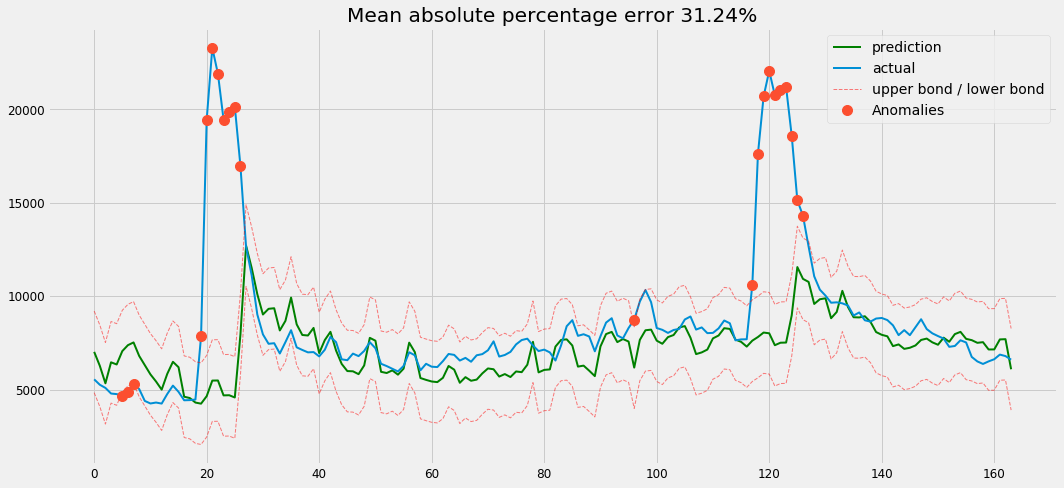

In [189]:
vr = VotingRegressor(
    estimators=[('ridge', reg1), ('lasso', reg2), ('gbr', reg3), ('elastic', reg4), ('randomf', reg5)],
    weights=[2, 1, 1, 1, 3]
)
vr = vr.fit(X_train, y_train)

plotModelResults(vr,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

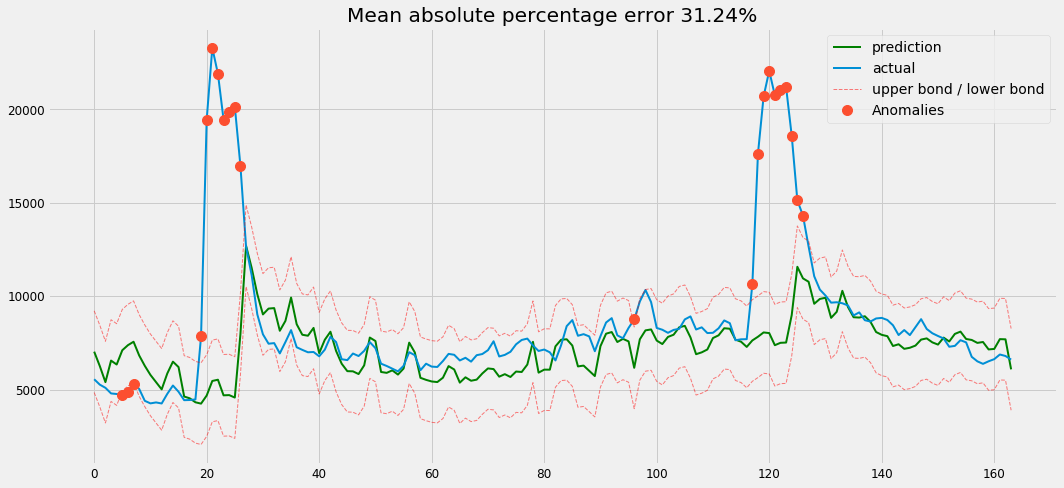

In [178]:
vr = VotingRegressor(
    estimators=[('ridge', reg1), ('lasso', reg2), ('gbr', reg3), ('elastic', reg4), ('randomf', reg5)],
    weights=[1, 1, 1, 2, 3]
)
vr = vr.fit(X_train, y_train)

plotModelResults(vr,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

In [179]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=20)
rfr.fit(X_train, y_train)

rf_param = {
    'n_estimators': [1000, 1500, 2000],
    'max_features': [0.7, 1.0],
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 3],
}
rf_search = GridSearchCV(rfr, rf_param, cv=5,
                        scoring='neg_mean_squared_error',
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1)
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=20,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_featur

In [180]:
rf_search.best_params_

{'bootstrap': True,
 'max_features': 0.7,
 'min_samples_leaf': 3,
 'n_estimators': 1000}

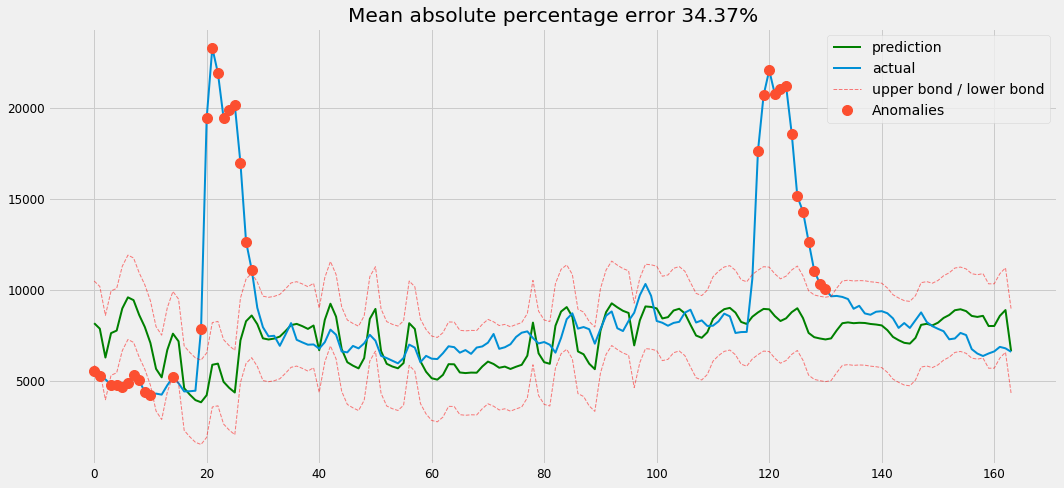

In [181]:
rf = rf_search.best_estimator_
rf.fit(X_train, y_train)
plotModelResults(rf,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

In [182]:
from sklearn.linear_model import ElasticNet

en = ElasticNet(random_state=20)
en.fit(X_train, y_train)

en_param = {
    'alpha': [0.4, 0.8, 1.0],
    'l1_ratio': [0.5, 0.6, 0.8, 1.0],
}

en_search = GridSearchCV(en, en_param, cv=5,
                        scoring='neg_mean_squared_error',
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1)
en_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=20, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.4, 0.8, 1.0],
                         'l1_ratio': [0.5, 0.6, 0.8, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=2)

{'alpha': 1.0, 'l1_ratio': 0.5}


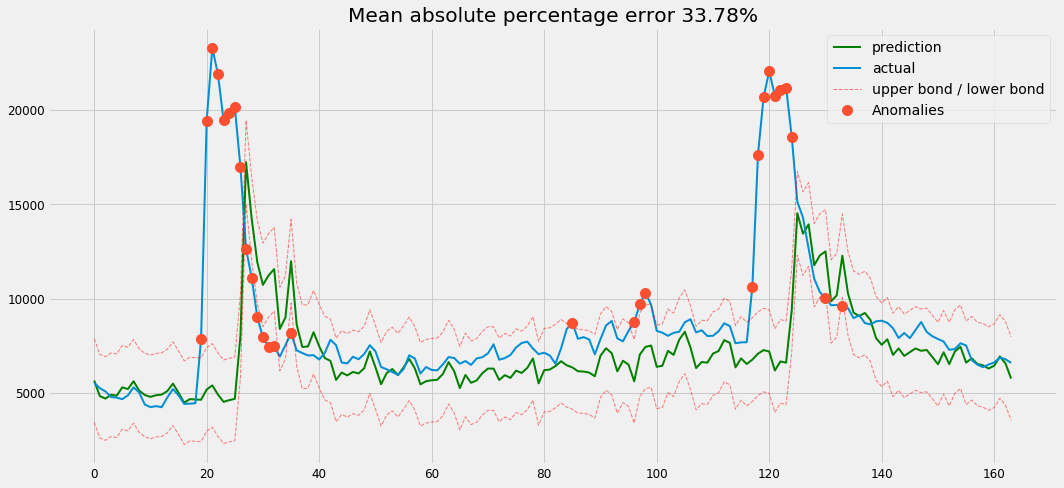

In [183]:
print(en_search.best_params_)
en = en_search.best_estimator_
plotModelResults(en,
                X_train=X_train,
                X_test=X_test,
                plot_intervals=True,
                plot_anomalies=True)

## Preditions

In [36]:
p_df = pd.read_excel('to_predict.xlsx', index_col=0, parse_dates=True)
p_data = pd.DataFrame(p_df['Daily User Uninstalls'].copy())
p_data.columns = ['y']

for i in range(lag_range[0], lag_range[1]):
  p_data['lag_{}'.format(i)] = p_data.y.shift(i)

X = p_data.dropna().drop(['y'], axis=1)

X.index = pd.to_datetime(X.index)
# X['day'] = X.index.day
X['weekday'] = X.index.weekday
X['is_weekend'] = X.weekday.isin([4,5,6])*1
X.tail()

FileNotFoundError: [Errno 2] No such file or directory: 'to_predict.xlsx'

In [ ]:
pred = vr.predict(X)
pd.DataFrame(pred)

In [ ]:
mae = pred.mean() * (-1)
deviation = pred.std()

scale = 1.8
lower = pred - scale * deviation
upper = pred + scale * deviation
upper

In [ ]:
X_scaled = scaler.fit_transform(X)
pred_s = xgb_s.predict(X_scaled)
pd.DataFrame(pred_s)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def GradientBooster(param_grid, n_jobs):
  estimator = GradientBoostingRegressor()
  cv = ShuffleSplit(X_train.shape[0], test_size=0.2, random_state=20)
  classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
  
  classifier.fit(X_train, y_train)
  
  print("Best estimator is {}".format(classifier.best_estimator_))
  
  return cv, classifier.best_estimator_

In [ ]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV

param_grid = {
    'n_estimators': [100, 60],
    'learning_rate': [0.005, 0.001, 0.003],
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4]
}
n_jobs = 10
cv, best_est = GradientBooster(param_grid, n_jobs)